In [1]:
# Images
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
import imgaug as aug
import imgaug.augmenters as imaug

# Toolbox
from pathlib import Path
from imutils import paths
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

# Misc
import progressbar
import random
import glob
import sys
import os
import warnings
warnings.filterwarnings(action='ignore')

# Deep learning
from keras.applications import ResNet50
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


### Helpers

In [2]:
def pct_bar_labels():
    '''
    Function used to label the relative frequency on top of each bars
    '''
    # Set font size
    fs=15
    
    # Set plot label and ticks
    plt.ylabel('Relative Frequency (%)', fontsize=fs)
    plt.xticks(rotation=0, fontsize=fs)
    plt.yticks([])
    
    # Set individual bar labels in proportional scale
    for x in ax1.patches:
        ax1.annotate(str(x.get_height()) + '%', 
        (x.get_x() + x.get_width()/2., x.get_height()), ha='center', va='center', xytext=(0, 7), 
        textcoords='offset points', fontsize=fs, color='black')

def freq_table(var):
    '''
    Define plot global variables
    Create a function that will populate a frequency table (%)
    Get counts per feature then get the percentage over the total counts
    '''
    global ax, ax1
    
    # Get values and pct and combine it into a dataframe
    count_freq = var.value_counts()
    pct_freq = round(var.value_counts(normalize=True)*100, 2)
    
    # Create a dataframe
    df = pd.DataFrame({'Count': count_freq, 'Percentage': pct_freq})
    
    # Print variable name
    print('Frequency of', var.name, ':')
    display(df)
    
    # Create plot
    ax1 = pct_freq.plot.bar(title='Percentage of {}'.format(var.name), figsize=(12,8))
    ax1.title.set_size(15)
    pct_bar_labels()
    plt.show()
    
# Define a null function
def get_nulls(df):
    
    # Get null pct and counts
    null_cols = pd.DataFrame(df.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(df.isnull().sum().sort_values(ascending=False)/len(df),2), columns=['Null Data Pct'])

    # Combine dataframes horizontally
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data Pct']>0]

    # Print
    print('There are', len(all_nulls), 'columns with missing values.')
    return all_nulls

# Define plot_nulls function
def plot_nulls(train):
    # Get null pct and counts
    null_cols = pd.DataFrame(train.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(train.isnull().sum().sort_values(ascending=False)/len(train),2)*100, columns=['Null Data %'])

    # Combine horizontally (axis=1) into a dataframe with column names (keys=[]) then to a data frame
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data %']>0]

    # Create figure space
    plt.figure(figsize=(12, 8))

    # Create plot
    sns.barplot(x=all_nulls.index,
                y='Null Data %',
                data=all_nulls)

    # Set plot features
    plt.xticks(rotation='90')
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of Missing Values', fontsize=15)
    plt.title('Percent of Missing Data by Features', fontsize=15)
    plt.show()

### Set directory

In [3]:
# Set directory
PATH = 'C:\\Users\\' + os.getlogin() + '\\Documents\\Programming\\DeepLearning\\09-dog-cat-classifier\\images'
os.chdir(PATH)
os.getcwd()
os.listdir()

['dog.png', 'original_test', 'original_train', 'test', 'train']

### Get test and train folders

In [4]:
# # Use Path()
# MAIN_PATH = Path(PATH)

# # Train folder
# train_dir = MAIN_PATH / 'original_train'

# # Test folder
# test_dir = MAIN_PATH / 'original_test'

In [5]:
args = {
    'dataset': 'original_train',
    'batch_size': 32,
}

# Store the batch size
bs = args["batch_size"]

imagePaths = list(paths.list_images(args['dataset']))
random.shuffle(imagePaths)
print(len(imagePaths))

25000


In [6]:
imagePaths[0]

'original_train\\cat.9417.jpg'

### Extract class labels from the path

In [7]:
imagePaths[0].split(os.path.sep)

['original_train', 'cat.9417.jpg']

In [8]:
os.path.sep

'\\'

In [9]:
imagePaths[0].split(os.path.sep)[-1]

'cat.9417.jpg'

In [10]:
imagePaths[0].split(os.path.sep)[-1].split('.')[0]

'cat'

### Get labels and encode dog/cat to 1/0

In [11]:
# Replace training_path[0] with loop
labels = [img.split(os.path.sep)[-1].split('.')[0] for img in imagePaths]

In [12]:
# Encode dog/cat to 1/0
le = LabelEncoder()
labels = le.fit_transform(labels)

### Plot

Frequency of Class :


,Count,Percentage
1,12500,50.0
0,12500,50.0


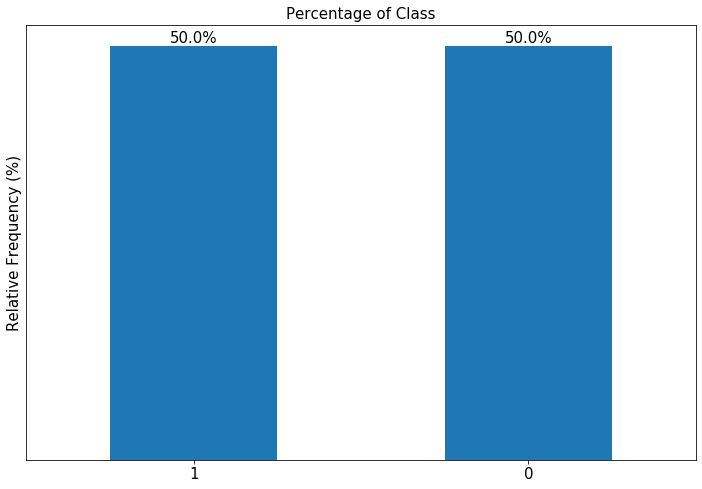

In [13]:
freq_table(pd.DataFrame(labels, columns=['Class']).Class)

In [14]:
# Check labels
labels

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

### Load pre-trained ResNet50 network for feature extraction

In [15]:
# Do not include the top fcn; this will enable us to perform feature extraction
model = ResNet50(weights='imagenet', include_top=False)

Instructions for updating:
Colocations handled automatically by placer.


### Initialize progress bar

Widget used to show progress.

In [16]:
widget = ['Extracting features: ', progressbar.Percentage(), ' ', progressbar.Bar(), ' ', progressbar.ETA()]
pbar = progressbar.ProgressBar(maxval=len(imagePaths), widgets=widget).start()

### Loop over image paths individually and build batches

In [18]:
%%time

# Create empty data matrix to store features
data = None

''' Part 1: Looping through the images in the path'''
# Loop over the images in batches
for i in np.arange(0, len(imagePaths), bs): # len(imagePaths)
    ''' 
    Extract the batch of images and labels and then initialize the list of images
    that will be passed through the network for feature extraction
    '''
    batchPaths = imagePaths[i:i + bs]
    batchLabels = labels[i:i + bs]
    batchImages = []
    
    ''' Part 2: Loading the image and changing them into arrays'''
    # Loop over the images and labels in the current batch
    for (j, imagePath) in enumerate(batchPaths):
        # Load the input image using load_img() and resize to (224, 224)
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
        
        # Preprocess the image by expanding the dimensions and subtracting the mean RGB pixel intensity
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
        
        # Add image to the batch list
        batchImages.append(image)
    
    ''' Part 3: Passing the new image arrays to be used as features
    
    For each batch of images, we pass it through the network and treat the output of our max pooling
    layer as our features.
    
    We flatten the output of the max pooling layer into a 2048-d feature vector. The features are stacked
    together in a data matrix so we can train a model on them.
    
    '''
    
    # Pass the images through the network and use the outputs as actual features
    batchImages = np.vstack(batchImages) # update array format
    features = model.predict(batchImages, batch_size=bs)
#     print(features.shape)
    
    # Reshape the features so that each image is represented by a flattened feature vector of MaxPooling2D outputs
    features = features.reshape((features.shape[0], 2048, -1)) # flatten
    
    # If data matrix is None; initialize
    if data is None:
        data = features
    # Stack the data and features together if there are values
    else:
        data = np.vstack([data, features])
    
    # Update progress bar
    pbar.update(i)
    
# Finish the progress bar
pbar.finish()

Wall time: 13min 28s


In [19]:
features.shape

(8, 2048, 49)

In [20]:
print(data.shape)
print(data.nbytes)

(25000, 2048, 49)
10035200000


### Train a logistic regression model with grid search

In [21]:
%%time

# Determine the index of the training and testing split
split_i = int(data.shape[0] * 0.75)

Wall time: 0 ns


In [ ]:
%%time

# Define the set of parameters we want to tune
print('Tuning hyperparameters...')
params = {
    'C': [0.0001, 0.001, 0.01]
}

# Grid search cross-validation
lr = LogisticRegression()
clf = GridSearchCV(lr, params, cv=3, n_jobs=-1)
clf.fit(data[:split_i], labels[:split_i])

In [ ]:
print('Best hyperparameters : {}'.format(clf.best_params_))

In [ ]:
# Classification report
print("Evaluating...")
preds = clf.predict(data[i:])
print(classification_report(labels[i:], preds, target_names=le.classes_))

# Compute the raw accuracy with extra precision
acc = accuracy_score(labels[i:], preds)
print("Score: {}".format(acc))